# 3.1 Aggregation Tutorial

## About

This notebook contains a minimal example for running workflows on aggregates of jobs using **signac-flow**. 

## Author

Hardik Ojha

## Prerequisites

This notebooks requires the following packages:

1. **signac-flow** >= 0.15
2. numpy
3. matplotlib

Execute the command below to install the required packages:
```bash
pip install signac-flow>=0.15 matplotlib numpy
```

## Definition

Aggregation allows a **signac-flow** operation to act on multiple jobs, rather than one job at a time.

An aggregate is defined as a subset of the jobs in a **signac** project. Aggregates are generated when a `flow.aggregator` object is applied to the `FlowProject.operation` directive.

Please refer to the [documentation](https://docs.signac.io/en/latest/aggregation.html) for detailed instructions on how to use aggregation.

## Objective

The goal of this project is to plot the temperature values present in a **signac** data space along with the average value of all the temperatures present.

## Project Setup

Before we initialize a **signac** project inside the `projects/tutorial-aggregation` directory, we need to be sure that no such directory exists. Uncomment before executing the below cell to remove the directory if exists.

In [1]:
# !rm -rf projects/tutorial-aggregation

In [2]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import signac
from flow import FlowProject, aggregator

# Setting default figure size
plt.rcParams["figure.figsize"] = (10, 4)


# Initializing a signac project
project = signac.init_project(
    "AggregationTutorialProject", "projects/tutorial-aggregation"
)

## Initializing the data space

For the purpose of this notebook, we will be creating a random dataset using some mathematical calculations.

All the **signac** jobs will have two state point parameters and one document value.

- `job.statepoint["city"]`: City for which data is being collected.
- `job.statepoint["day"]`: Day of the year.
- `job.document["temperature"]`: Average temperature for that day.

In [3]:
days = np.arange(365)


def generate_temperatures(days, seed=None):
    rng = np.random.default_rng(seed)
    avg_temperature = 10 + rng.random() * 10
    annual_variation = -10 * np.cos(days / 365 * 2 * np.pi)
    random_variation = 5 * rng.random(len(days))
    temperatures = avg_temperature + annual_variation + random_variation
    return temperatures


temperatures = generate_temperatures(days, seed=123)

for day, temperature in zip(days.tolist(), temperatures.tolist()):
    # Create a signac job having the state point parameters 'day' and 'temperature'
    statepoint = dict(city="Anytown", day=day)
    job = project.open_job(statepoint)
    job.document["temperature"] = temperature

Let's look at the project schema to see the jobs that were created.

In [4]:
project.detect_schema()

ProjectSchema(<len=2>)

## Creating a FlowProject with aggregate operations

In order to achieve our goal using **signac-flow**, we need to create a `FlowProject` and add operations to it.
There will be following operations in our workflow:

1. `compute_average_temperature`: This operation computes the average temperature of the year and stores it in the project document. For this operation, all the jobs present in the **signac** project will be aggregated together. This will be the first operation to get executed in our workflow.
2. `plot_deviation_from_average`: This operation plots the temperature (as a scatter plot) and the average temperature of the month. For this operation, all the jobs, when sorted by the state point parameter `day`, present in the **signac** project will be aggregated together. This will be executed after the operation `compute_average_temperature`.

In [5]:
class AggregationProject(FlowProject):
    pass


@AggregationProject.operation(aggregator=aggregator=())
@AggregationProject.post(lambda *jobs: project.doc.get("average_temperature", False))
def compute_average_temperature(*jobs):
    """Compute the average temperature using the state point parameter,
    "temperature", of all jobs present in the signac project and
    store the computed value to the project document.
    """
    average_temp = np.mean([job.document["temperature"] for job in jobs])
    project.document["average_temperature"] = float(average_temp)


@AggregationProject.operation(aggregator=aggregator(sort_by="day"))
@AggregationProject.pre.after(compute_average_temperature)
def plot_daily_temperature(*jobs):
    """Graph of daily temperature for the year."""
    print("Generating plot of daily temperature.")
    average_temp = project.document["average_temperature"]
    days = [job.sp["day"] for job in jobs]
    fig, ax = plt.subplots()
    ax.plot(
        days,
        [job.document["temperature"] for job in jobs],
        "rx",
        label="Daily Temperature (°C)",
    )
    # Plot the average as a line
    ax.axhline(average_temp, c="green", label="Average Annual Temperature (°C)")
    ax.legend()
    ax.set_xlabel("Day")
    ax.set_ylabel("Temperature (°C)")
    plt.show()



@AggregationProject.operation(aggregator=aggregator(sort_by="day", select=lambda job: job.sp["day"] % 7 == 0))
def plot_weekly_temperature(*jobs):
    """Graph the temperature for only one day of each week."""
    print("Generating plot of weekly temperature.")
    days = [job.sp.day for job in jobs]
    fig, ax = plt.subplots()
    ax.plot(
        days,
        [job.document["temperature"] for job in jobs],
        "rx",
        label="Daily Temperature (°C)",
    )
    ax.set_xlabel("Day")
    ax.set_ylabel("Temperature (°C)")
    plt.show()

## Executing the workflow

### Initializing the FlowProject
In order to register the operations, conditions, and the aggregators associated with the project we created, we need to initialize a `FlowProject`.
Since the **signac** project does not belong in the current directory, we specify its path to `FlowProject.get_project`.

In [6]:
flow_project = AggregationProject.get_project(project.root_directory())

### Running the workflow
The `FlowProject.run` method allows the execution all eligible operations in the `FlowProject`.

Generating plot of daily temperature.


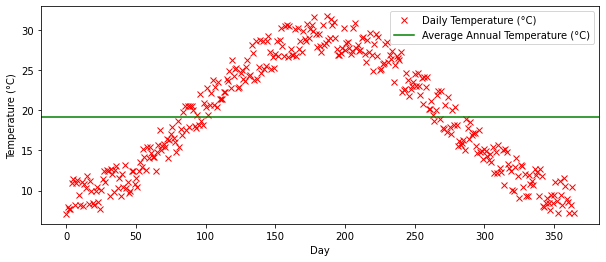

Generating plot of weekly temperature.


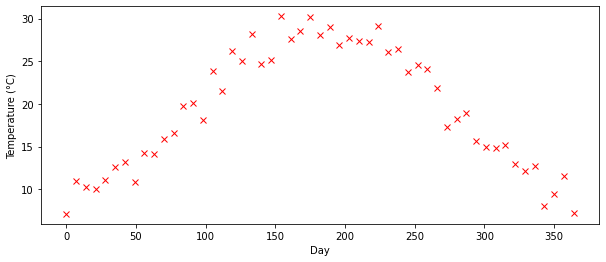

Operation 'plot_weekly_temperature' has no postconditions!
Operation 'plot_daily_temperature' has no postconditions!


In [7]:
flow_project.run()

## Summary

We have successfully plotted the temperature values present in a **signac** data space along with the average value of all the temperatures present using the aggregation feature of **signac-flow**.

To learn more about how to use aggregation, see the [documentation on aggregation](https://docs.signac.io/en/latest/aggregation.html).